##RAG Privacy Policy Simplifier (TikTok PoC)



**Project type:** Proof-of-Concept (PoC)  
**Input:** fittiching Privacy policy URL online  
**Output:** Simplified rewrite in clear English  
**Main idea:** Use **RAG** to reduce hallucination and summarization and highlighting


## 1) Problem Statement

Privacy policies are tooo long and written in legal language. Most users dont read them fully or they misunderstand what data is collected, how it is used, and who it is shared with. Normal summarizers can also **hallucinate** or **drop important details**

## 2) Goal

Build a lightweight end-to-end **RAG pipeline** that rewrites (not invents) or omit privacy policy text into **clear, simple English** while preserving meaning and reducing hallucination risk. This is mainly to **prove the idea works** before heavy optimization


## 3) Scope

**Included:**
- Fetch policy text from official URL
- Clean text (fix weird encoding chars)
- Chunking + embeddings + retrieval (Top-K)
- Rewrite with strict rules (no guessing)
- evalution

**Not included (for now):**
- Legal verification / lawyer review
- Perfect section-by-section formatting
- Multi-doc evaluation system (advanced scoring)
- Guarantee of 100% coverage


## **Model Development and Coding**

## Importing Libraries



In [1]:
!pip -q install -U transformers accelerate bitsandbytes sentence-transformers lxml textstat matplotlib
!pip -q install pandas==2.2.2 requests==2.32.4

import os
import re
import math
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import textstat

from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
if device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 140.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 89.1 MB/s eta 0:00:00
Device: cuda
GPU: NVIDIA L4


## Secure HF Token + Project Configration

In [2]:
from getpass import getpass

if not os.getenv("HF_TOKEN"):
    print("\nHF_TOKEN not found in environment.")
    print("Paste your HuggingFace token (input will be hidden):")
    os.environ["HF_TOKEN"] = getpass("HF_TOKEN: ")

hf_token = os.getenv("HF_TOKEN", "")
print("HF_TOKEN detected:", bool(hf_token), "| length:", len(hf_token))

if len(hf_token.strip()) < 20:
    raise EnvironmentError(
        "HF_TOKEN is missing or too short.\n"
        "Fix: Paste a valid token when prompted, then rerun this block."
    )

print("HF_TOKEN check passed.")

POLICY_URLS = [
    "https://www.tiktok.com/legal/privacy-policy?lang=en"
]

RETRIEVAL_QUERY = "data collection, sharing, retention, rights, security, advertising, tracking"

# Chunking knobs
CHUNK_WORDS = 500  # after lots of trials this were the best threshould for me
CHUNK_OVERLAP = 80
MIN_CHUNK_WORDS = 120

# Retrieval knobs
TOP_K = 12  # this is after alot of trials i started with 6 but if you prefer more coverage, ok

# Models
EMBED_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
GEN_MODEL_NAME   = "mistralai/Mistral-7B-Instruct-v0.2"

# Generator knobs
GEN_MAX_NEW_TOKENS = 1400 #to make it stable



HF_TOKEN not found in environment.
Paste your HuggingFace token (input will be hidden):
HF_TOKEN: ··········
HF_TOKEN detected: True | length: 37
HF_TOKEN check passed.


##Fetching Polices + Generic cleaning

In [3]:
def _normalize_whitespace(s: str) -> str:
    s = s.replace("\u00a0", " ")
    s = re.sub(r"[ \t]+", " ", s)
    s = re.sub(r"\n{3,}", "\n\n", s)
    return s.strip()

def fix_mojibake(s: str) -> str:
    return (s.replace("â", "'")
             .replace("â", '"')
             .replace("â", '"')
             .replace("â", "-")
             .replace("Â", " ")
             .strip())

def fetch_policy(url: str, timeout: int = 30) -> str:
    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept-Language": "en-US,en;q=0.9",
    }
    r = requests.get(url, headers=headers, timeout=timeout)
    if r.status_code != 200:
        preview = (r.text or "")[:200]
        raise RuntimeError(f"Fetch failed: {r.status_code}\nPreview:\n{preview}")

    soup = BeautifulSoup(r.text, "lxml")

    for tag in soup(["script", "style", "noscript"]):
        tag.decompose()

    main = soup.find("main") or soup.find("article")
    text = main.get_text("\n") if main else soup.get_text("\n")

    text = _normalize_whitespace(text)
    text = fix_mojibake(text)
    return text

def clean_text(raw: str) -> str:
    before = len(raw)
    lines = [ln.strip() for ln in raw.splitlines()]
    lines = [ln for ln in lines if len(ln) > 2]
    cleaned = "\n".join(lines)
    cleaned = _normalize_whitespace(cleaned)
    cleaned = fix_mojibake(cleaned)
    after = len(cleaned)
    print(f"Cleaned chars: {after} (removed ~{max(0, before-after)} chars)")
    return cleaned

def preview_head_tail(text: str, n: int = 1200) -> None:
    print("\n" + "="*70)
    print(f"TEXT STATS | chars: {len(text)} | words: {len(text.split())}")
    print("="*70)
    print("\n[HEAD PREVIEW]\n")
    print(text[:n])
    print("\n" + "-"*70)
    print("\n[TAIL PREVIEW]\n")
    print(text[-n:])
    print("\n" + "="*70 + "\n")

policies = []
for url in POLICY_URLS:
    print("\nFetching:", url)
    raw = fetch_policy(url)
    text = clean_text(raw)

    if len(text) < 20000:
        print("WARNING: Policy text looks too short (<20k chars). It may be incomplete")

    preview_head_tail(text, n=1200)
    policies.append({"url": url, "text": text})

# Optional manual override: because after alot of trials many of polcies are pages are protected from fitiching
MANUAL_POLICY_TEXT = ""
if MANUAL_POLICY_TEXT.strip():
    policies = [{"url": "MANUAL_INPUT", "text": clean_text(MANUAL_POLICY_TEXT)}]
    preview_head_tail(policies[0]["text"], n=1200)



Fetching: https://www.tiktok.com/legal/privacy-policy?lang=en
Cleaned chars: 50903 (removed ~103 chars)

TEXT STATS | chars: 50903 | words: 8237

[HEAD PREVIEW]

Privacy Policy | TikTok
Other regions
Privacy Policy
Last updated: July 8, 2025
Welcome to TikTok. This Privacy Policy applies to TikTok services, which include TikTok apps, websites, software and related services (the "Platform"). The Platform is provided and controlled by TikTok Pte. Ltd., with its registered address at 1 Raffles Quay, #26-10, South Tower, Singapore 048583 ("TikTok", "we" or "us").
We are committed to protecting and respecting your privacy. This Privacy Policy explains how we collect, use, share, and otherwise process the personal information of users, and other individuals. If you do not agree with this policy, you should not use the Platform.
What information we collect
We may collect the following information about you:
Information You Provide
Your account information.
You give us information when you re

I pulled the TikTok policy text from the link and cleaned the messy lines.
I checked the **head** and **tail** to make sure the page is not empty or cut.
It looks full length (big **word count**), so i can move to chunking now.


##**(RAG pipeline)**

##Chunking
split policy into overlapping chunks

Drop very tiny chunks (noise)


In [4]:
def chunk_text(text: str, chunk_words: int = 500, overlap_words: int = 80, min_words: int = 120) -> list[str]:
    words = text.split()
    chunks = []
    i = 0
    step = max(1, chunk_words - overlap_words)

    while i < len(words):
        chunk_words_list = words[i:i + chunk_words]
        chunk = " ".join(chunk_words_list).strip()
        if chunk and len(chunk_words_list) >= min_words:
            chunks.append(chunk)
        i += step

    return chunks

def chunk_stats(chunks: list[str]) -> None:
    sizes = [len(c.split()) for c in chunks]
    print(f"Chunks: {len(chunks)} | words min/avg/max: {min(sizes)}/{sum(sizes)//len(sizes)}/{max(sizes)}")

def preview_chunks(chunks: list[str], take: int = 2, chars: int = 800) -> None:
    take = min(take, len(chunks))
    for idx in range(take):
        print("\n" + "="*70)
        print(f"CHUNK #{idx} | words: {len(chunks[idx].split())}")
        print("="*70)
        print(chunks[idx][:chars])
        print("\n" + "="*70)

for p in policies:
    chunks = chunk_text(p["text"], CHUNK_WORDS, CHUNK_OVERLAP, MIN_CHUNK_WORDS)

    if len(chunks) < 6:
        print("WARNING: Few chunks (<6). !!!!")

    chunk_stats(chunks)
    preview_chunks(chunks, take=2, chars=800)
    p["chunks"] = chunks


Chunks: 20 | words min/avg/max: 257/487/500

CHUNK #0 | words: 500
Privacy Policy | TikTok Other regions Privacy Policy Last updated: July 8, 2025 Welcome to TikTok. This Privacy Policy applies to TikTok services, which include TikTok apps, websites, software and related services (the "Platform"). The Platform is provided and controlled by TikTok Pte. Ltd., with its registered address at 1 Raffles Quay, #26-10, South Tower, Singapore 048583 ("TikTok", "we" or "us"). We are committed to protecting and respecting your privacy. This Privacy Policy explains how we collect, use, share, and otherwise process the personal information of users, and other individuals. If you do not agree with this policy, you should not use the Platform. What information we collect We may collect the following information about you: Information You Provide Your account information


CHUNK #1 | words: 500
in your device's clipboard , with your permission. For example, if you choose to initiate content sharing wi

look i chunked the policy into ~500-word parts with a small **overlap** so the edges dont cut meanings
ended up with **20 chunks**, most of them near the same size, so retrieval should be stable i think
the small last chunk is normal,

##Embeddings + Retrieval

In [5]:
embedder = SentenceTransformer(EMBED_MODEL_NAME)

def embed_chunks(chunks: list[str]) -> tuple[np.ndarray, list[str]]:
    chunks_clean = [c.strip() for c in chunks if c and c.strip()]
    emb = embedder.encode(chunks_clean, normalize_embeddings=True, show_progress_bar=False)
    return np.array(emb), chunks_clean

def retrieve_topk(chunks: list[str], chunk_emb: np.ndarray, query: str, top_k: int):
    q_emb = embedder.encode([query], normalize_embeddings=True, show_progress_bar=False)[0]
    scores = chunk_emb @ q_emb
    k = min(top_k, len(scores))
    top_idx = np.argsort(-scores)[:k].tolist()
    return top_idx, [chunks[i] for i in top_idx], [float(scores[i]) for i in top_idx]

def preview_retrieved(indices, retrieved, scores, chars: int = 800):
    print("\nRetrieved chunk indices:", indices)
    for j, (idx, txt, sc) in enumerate(zip(indices, retrieved, scores)):
        print("\n" + "=" * 70)
        print(f"RETRIEVED #{j} | chunk={idx} | score={sc:.4f} | words={len(txt.split())}")
        print("=" * 70)
        print(txt[:chars])
        print("\n" + "=" * 70)

for p in policies:
    p["chunk_emb"], p["chunks_clean"] = embed_chunks(p["chunks"])

    print(f'\n[RAG] url={p.get("url","")} | chunks={len(p["chunks_clean"])} | TOP_K={TOP_K}')
    idxs, retrieved, scores = retrieve_topk(p["chunks_clean"], p["chunk_emb"], RETRIEVAL_QUERY, TOP_K)

    preview_retrieved(idxs, retrieved, scores, chars=800)

    p["retrieved_idxs"] = idxs
    p["retrieved_texts"] = retrieved
    p["retrieved_scores"] = scores


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


[RAG] url=https://www.tiktok.com/legal/privacy-policy?lang=en | chunks=20 | TOP_K=12

Retrieved chunk indices: [6, 4, 2, 5, 7, 14, 1, 3, 19, 15, 17, 0]

RETRIEVED #0 | chunk=6 | score=0.5450 | words=500
providers of content moderation services to ensure that the Platform is a safe and enjoyable place and service providers that assist us in marketing the Platform. Payment processors and transaction fulfillment providers : If you choose to buy Coins or conduct other payment related transactions, we will share data with the relevant payment provider to facilitate this transaction. For Coin transactions, we share a transaction ID to enable us to identify you and credit your account with the correct value in coins once you have made the payment. Analytics providers: We use analytics providers to help us in the optimisation and improvement of the Platform. Our third-party analytics providers also help us serve personalised advertisements. Advertisers, Advertising Networks, Publishers, and M

look i ran embeddings on the **20 chunks** and pulled **TOP_K=12**
top results look real tbh: sharing, ads/analytics, location, security, transfers, contacts, purchases, and rights

scores are mostly ~0.50 which is fine, and the few lower ones are just country add-on parts, not random junk or noise

now i can feed these retrieved chunks into the generator


## Load Generator Model (Mistral 7B Instruct, 4-bit)

Load tokenizer + model

4-bit quantization to fit GPU

In [6]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(GEN_MODEL_NAME, token=hf_token, use_fast=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    GEN_MODEL_NAME,
    token=hf_token,
    quantization_config=bnb_config,
    device_map="auto",
)
model.eval()

print("Loaded generator:", GEN_MODEL_NAME)
print("pad_token_id:", tokenizer.pad_token_id)


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Loaded generator: mistralai/Mistral-7B-Instruct-v0.2
pad_token_id: 2


I loaded the **generator model** (Mistral 7B Instruct) and it finished without errors
So now the model is ready

##Rewrite/Simplify

In [7]:
def build_context_from_idxs(all_chunks: list[str], idxs: list[int], max_chunks: int = 11, per_chunk_chars: int = 1200) -> str:
    uniq = sorted(set(idxs))[:max_chunks]
    chosen = []
    for i in uniq:
        c = (all_chunks[i] or "").strip()
        c = fix_mojibake(c)
        if c:
            chosen.append(c[:per_chunk_chars])
    return "\n\n".join(chosen)

def cleanup_output(text: str) -> str:
    t = fix_mojibake(text.replace("\r", "")).strip()
    t = re.sub(r"\n{3,}", "\n\n", t)
    t = re.sub(r"\.{2,}", ".", t)      # remove ".. .. .."
    t = t.replace("<", "").replace(">", "")
    return t.strip()

def generate_rewrite(context: str, max_new_tokens: int = 1400) -> str:
    user_prompt = (
        "Task: Rewrite this privacy policy in clear, simple English for an average user.\n\n"
        "Strict rules:\n"
        "- Preserve the meaning. Do not add, guess, or invent anything.\n"
        "- Do not merge different parts in a way that changes meaning.\n"
        "- If something is unclear or not explicitly stated, omit it.\n"
        "- Use short paragraphs only. No bullet lists. No numbering.\n"
        "- Avoid unusual symbols. Use normal punctuation only.\n"
        "- Do not repeat the same idea again and again. If you start repeating, stop.\n\n"
        "Text:\n"
        f"{context}\n"
    )

    messages = [{"role": "user", "content": user_prompt}]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True) if hasattr(tokenizer, "apply_chat_template") else user_prompt

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=5500)
    input_len = inputs["input_ids"].shape[-1]
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            repetition_penalty=1.12,
            no_repeat_ngram_size=8,
            pad_token_id=tokenizer.eos_token_id,
        )

    gen_tokens = out[0][input_len:]
    return cleanup_output(tokenizer.decode(gen_tokens, skip_special_tokens=True))

TOP_K_FOR_GEN = min(11, TOP_K)

for p in policies:
    context = build_context_from_idxs(
        all_chunks=p["chunks"],
        idxs=p["retrieved_idxs"],
        max_chunks=TOP_K_FOR_GEN,
        per_chunk_chars=1200
    )

    print(f"\n[GEN] url={p['url']} | context_chunks={min(TOP_K_FOR_GEN, len(set(p['retrieved_idxs'])))}")
    simplified = generate_rewrite(context, max_new_tokens=GEN_MAX_NEW_TOKENS).strip()

    simplified += (
        "\n\n---\n"
        "Note (experimental): This summary is for learning/testing purposes only and may contain mistakes. "
        "The official and legally binding text is the original privacy policy.\n"
        "Ahmed Wadee Moustafa"
    )

    p["simplified"] = simplified

    print("\n" + "="*90)
    print("SIMPLIFIED OUTPUT")
    print("="*90)
    print(simplified)
    print("="*90 + "\n")



[GEN] url=https://www.tiktok.com/legal/privacy-policy?lang=en | context_chunks=11

SIMPLIFIED OUTPUT
Welcome to TikTok! Here's how we handle your information on our apps, websites, and related services:

We collect several types of information:

* Information you give us: This includes your account details like username, password, email address, phone number, and profile picture. Also, the content you create, such as photos, videos, and comments.
* Device contacts: If you choose to sync your phone or social network contacts, we access and collect names, phone numbers, and email address to match them with existing TikTok users.
* Location information: We gather your approximate location from your SIM card and IP address. With your permission, precise location data like GPS is also collected.
* Image and audio information: We analyze videos, images, and audio in your content to enhance special effects, moderate content, classify demographics, recommend content, and provide personalized 

I ran the **trial summary** and as a normal user Id rate it about **6.5/10** (as proof, not perfect)
The **good part** is it matched the real chunks: **location (approx + GPS)**, **image/audio analysis**, **sharing with ads/analytics/payment**, and **data transfer** (Singapore/Malaysia/Ireland/US)
The **bad part** is small **over-talk / semi-hallucsination**: it used **bullet points** even tho we said “short paragrphs only”, and it wrote “you **consent**” which can be risky if the text didnt say it cleary
Also some lines are **too general** like “business partners for social networking”, feels broad and not super pinned to the exact wording


##Evaluation

,Policy,Version,FKGL,GunningFog,SMOG,Words,Chars
0,https://www.tiktok.com/legal/privacy-policy?la...,Before,14.822747,17.65520,15.787659,8237,50903
1,https://www.tiktok.com/legal/privacy-policy?la...,After,13.476316,16.49218,14.924445,374,2473


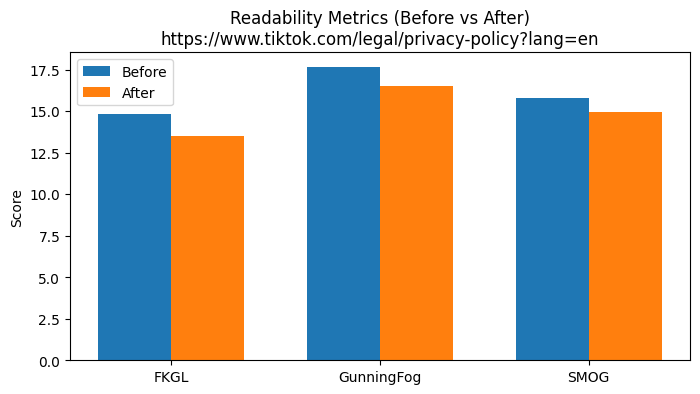

In [8]:
def compute_scores(text: str) -> dict:
    return {
        "FKGL": float(textstat.flesch_kincaid_grade(text)),
        "GunningFog": float(textstat.gunning_fog(text)),
        "SMOG": float(textstat.smog_index(text)),
        "Words": int(len(text.split())),
        "Chars": int(len(text)),
    }

rows = []
for p in policies:
    before = p["text"]
    after = p["simplified"]

    s_before = compute_scores(before)
    s_after = compute_scores(after)

    rows.append({"Policy": p["url"], "Version": "Before", **s_before})
    rows.append({"Policy": p["url"], "Version": "After", **s_after})

df = pd.DataFrame(rows)
display(df)

metrics = ["FKGL", "GunningFog", "SMOG"]

for policy_url in df["Policy"].unique():
    sub = df[df["Policy"] == policy_url].set_index("Version")
    before_vals = [sub.loc["Before", m] for m in metrics]
    after_vals = [sub.loc["After", m] for m in metrics]

    x = np.arange(len(metrics))
    w = 0.35

    plt.figure(figsize=(8, 4))
    plt.bar(x - w/2, before_vals, width=w, label="Before")
    plt.bar(x + w/2, after_vals, width=w, label="After")
    plt.xticks(x, metrics)
    plt.ylabel("Score")
    plt.title(f"Readability Metrics (Before vs After)\n{policy_url}")
    plt.legend()
    plt.show()

I checked the **scores table** and its clear the output is waaay shorter than the real policy
The original is **8237 words**, but the rewrite is only **374 words**, so it’s more like a tiny summary not a full simplifed policy
Readability got a bit better (**FKGL / Fog / SMOG** drop), but it’s still kinda high, so the language is still “legal-ish”
So for now it’s ok as a **trial proof**, but later I need either **more tokens** or a **chunk-by-chunk rewrite** or even more maybe even paid models and gpu powerif I want more lenght
